# MIDDEN Salt Model - Open Exploration

## Model initialization

In [1]:
from __future__ import (division, print_function, absolute_import, unicode_literals)
from ema_workbench import (RealParameter, IntegerParameter, TimeSeriesOutcome, ScalarOutcome, 
                           ema_logging, perform_experiments, save_results, load_results)
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.em_framework import (salib_samplers, samplers, util,
                                        MultiprocessingEvaluator, SequentialEvaluator) 
from ema_workbench.analysis import prim
from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

import numpy.lib.recfunctions as rf
import numpy as np
import matplotlib.pyplot as plt
import mpld3
import pandas as pd

C:\Users\Edzard\Anaconda\lib\site-packages\ema_workbench\connectors\__init__.py:18: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)
C:\Users\Edzard\Anaconda\lib\site-packages\xarray\core\formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime
C:\Users\Edzard\Anaconda\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Edzard\Anaconda\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
ema_logging.log_to_stderr(level=ema_logging.INFO)

model = ExcelModel("excelmodel", wd="./Models", model_file='MIDDEN Decarbonization options salt final.xlsx')

#name of the sheet
model.sheet = "Experiment"

# Specification of the uncertainties
model.uncertainties = [IntegerParameter("Price_scenario", 1, 3),               # Integer value 1, 2, 3
                       RealParameter("Discount_rate", 0.0075, 0.075),           # May fluctuate between 2% and 5%
                       RealParameter("Production_uncertainty", 0.95, 1.05),    # May fluctuate between between 85% and 115% 
                       RealParameter("Efficiency_gain", 0.0015, 0.0075),       # Yearly efficiency gain approx 0.5% (DNGVL)
                       IntegerParameter("Investment_year", 2020, 2025)         # Integer value range 2020 – 2030
                      ]


# Specification of the policies
model.levers = [IntegerParameter('Electric_boiler_investments', 0, 3),        # 0=None; 1=Electric boilers; 2=MVR technology; 3=Hybrid
                IntegerParameter('MVR_investments', 0, 3), # 0=None; 1=Electric boilers; 2=MVR technology; 3=Hybrid
                IntegerParameter('Energy_tax', 0, 2),               # 0=None; 1=10%; 2=20%
                IntegerParameter('Coal_plants_shutdown', 0, 1)     # 0=Present policy, 1=Envisaged policy
               ]

# Specification of the outcomes
model.outcomes = [ScalarOutcome("Direct_emissions_2030", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Direct_emission_change", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Indirect_emissions_2030", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Indirect_emission_change", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Total_emissions_2030", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Total_emission_change", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("IRR", kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome("NPV", kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome("Investment_cost", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Yearly_production", kind=ScalarOutcome.MAXIMIZE)
                 ]

 ### Running experiment with policies


In [3]:
#Running with policies
n_scenarios = 500
n_policies = 96
results_bckp = './Data/Results salt - {} scenarios {} policies.tar.gz'.format(n_scenarios, n_policies)

counter = util.Counter()
policies = samplers.sample_levers(model, n_policies)

try:
    # Load results if experiment has already been conducted
    results = load_results(results_bckp)

except IOError:
    # Running in parallel   
    with MultiprocessingEvaluator(model) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, policies)
    
    #Running in series
    #results = perform_experiments(model, n_scenarios)
    
    save_results(results, results_bckp)

experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from C:\Users\Edzard\Documents\MIDDEN modeling\Data\Results salt - 500 scenarios 96 policies.tar.gz


In [4]:
# Creating experiment DataFrame
experiment_data=pd.DataFrame(experiments)
outcome_data = pd.DataFrame(outcomes)
results_df=pd.concat([experiment_data, outcome_data], axis=1)

## Feature scoring

In [5]:
import seaborn as sns
import numpy.lib.recfunctions as rf
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.feature_scoring import get_feature_scores_all

experiments, outcomes = results

C:\Users\Edzard\Anaconda\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Edzard\Anaconda\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


### Feature scoring uncertainties to performance metrics

In [6]:
# Defining the x space for feature scoring
x = experiments
x = rf.drop_fields(x, ['Electric_boiler_investments', 'MVR_investments', 'Energy_tax','Coal_plants_shutdown', 'Investment_year',
                       'policy','model'], 
                   asrecarray=True)

In [7]:
# Defining the y-space for the feature scoring
y_df = pd.DataFrame(outcomes)
y_df=y_df[['Direct_emission_change','Indirect_emission_change','Total_emission_change','NPV','IRR', 'Investment_cost']]

y_dict = y_df.to_dict('list')
for key in y_dict.keys():
    y_dict[key] = np.array(y_dict[key])

y = y_dict

In [8]:
fs_all = get_feature_scores_all(x, y)
fs_all

C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pas

,Direct_emission_change,Indirect_emission_change,Total_emission_change,NPV,IRR,Investment_cost
Discount_rate,0.201074,0.154619,0.070119,0.031851,0.314833,0.312732
Efficiency_gain,0.315790,0.184072,0.170806,0.017730,0.330003,0.310135
Price_scenario,0.090673,0.067793,0.039356,0.925615,0.043214,0.068520
Production_uncertainty,0.392463,0.593516,0.719720,0.024804,0.311950,0.308612


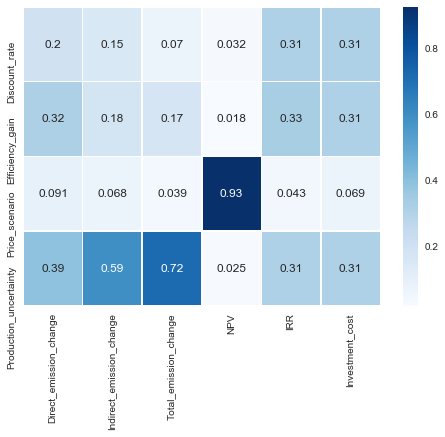

In [9]:
sns.heatmap(fs_all, annot=True, cmap='Blues', linewidths=0.5)
plt.show()

### Feature scoring for policy levers

In [10]:
# Defining the x space for feature scoring
x = experiments
x = rf.drop_fields(x, ['Discount_rate','Efficiency_gain','Price_scenario','Production_uncertainty',
                       'policy', 'model'], 
                   asrecarray=True)
fs_all = get_feature_scores_all(x, y)

C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pas

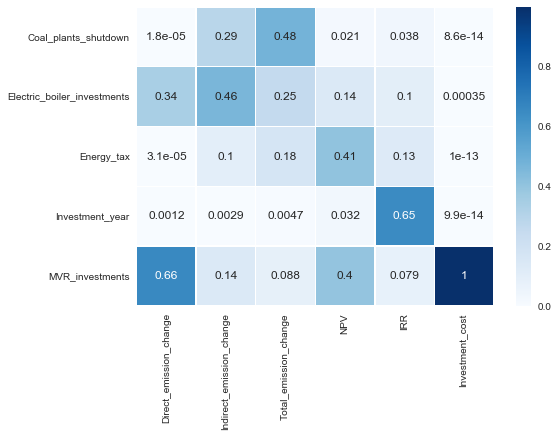

In [11]:
sns.heatmap(fs_all, annot=True, cmap='Blues', linewidths=0.5)
plt.show()

## Filtering output space to explore desired outcomes

In [12]:
import copy
data = copy.copy(outcomes)
data = pd.DataFrame(data)

In [13]:
# Filtering scenarios
data['NPV_pos']=data.NPV>0 
data['Direct_emissions_ETS'] = data.Direct_emissions_2030<490
data['Total_emission_change_neg'] = data.Total_emission_change<-65.88
results_df['Filter']= data['NPV_pos']&data['Direct_emissions_ETS']&data['Total_emission_change_neg']

In [14]:
filtered_results=results_df.loc[results_df['Filter']]

In [15]:
print(len(filtered_results), len(results_df), len(filtered_results)/len(results_df))

9851 48000 0.20522916666666666


C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pas

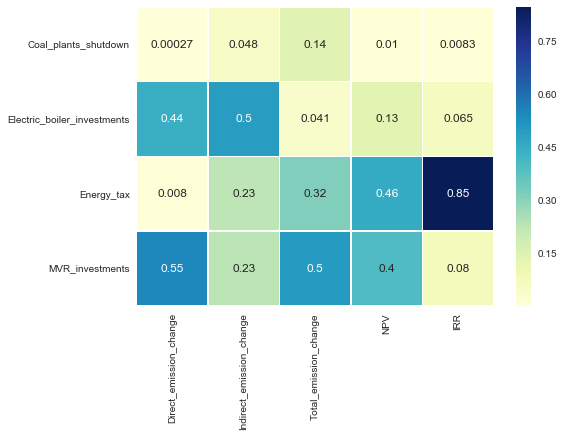

In [16]:
# Selecting relevant frames from filters 

# Policies
x_df = filtered_results[['Electric_boiler_investments','MVR_investments','Coal_plants_shutdown','Energy_tax']]
x = x_df.to_records(index=False)

# Outcomes
y_df = filtered_results[['Direct_emission_change','Indirect_emission_change','Total_emission_change','NPV','IRR']]
y_dict = y_df.to_dict('list')
for key in y_dict.keys():
    y_dict[key] = np.array(y_dict[key])

y = y_dict

fs_all = get_feature_scores_all(x, y)
sns.heatmap(fs_all, annot=True, cmap='YlGnBu', linewidths=0.5)
plt.show()

In [17]:
filtered_results[['Electric_boiler_investments','MVR_investments','Coal_plants_shutdown','Energy_tax']].std()

Electric_boiler_investments    1.104760
MVR_investments                0.764724
Coal_plants_shutdown           0.190138
Energy_tax                     0.713375
dtype: float64

In [18]:
filtered_results[['Electric_boiler_investments','MVR_investments','Coal_plants_shutdown','Energy_tax']].mean()

Electric_boiler_investments    1.122627
MVR_investments                2.370013
Coal_plants_shutdown           0.962440
Energy_tax                     1.431631
dtype: float64

## Dimensional stack 

In [19]:
print(np.sum(results_df['Filter']), len(results_df['Filter']), np.sum(results_df['Filter']) - len(results_df['Filter']),  np.sum(results_df['Filter'])/len(results_df['Filter']))

9851 48000 -38149 0.205229166667


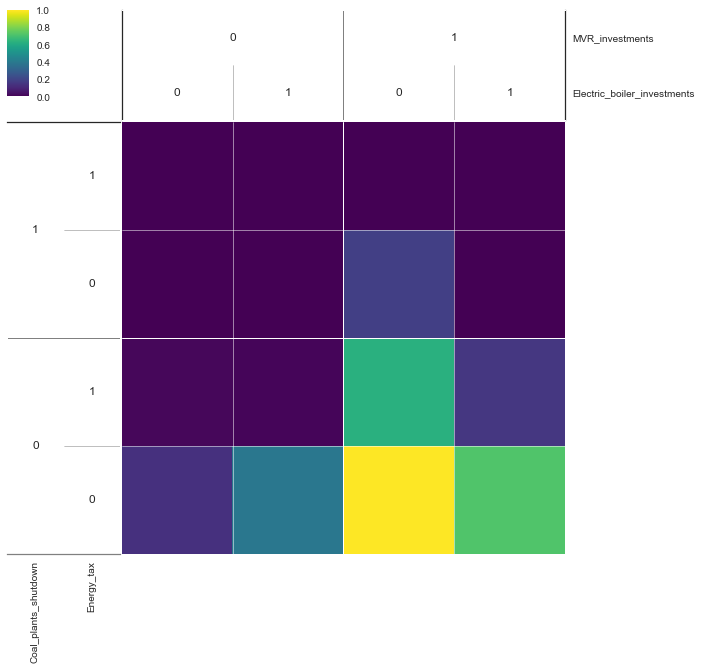

In [20]:
from ema_workbench.analysis import dimensional_stacking

# Selecting successful policies
x_df = results_df[['Electric_boiler_investments','MVR_investments', 
                         'Energy_tax','Coal_plants_shutdown' ]]
x = x_df.to_records(index=False)

# Filtering output space
y = np.array(results_df['Filter'])

dimensional_stacking.create_pivot_plot(x,y, nr_levels=2, nbins=2)
#plt.show()

## Visualizing filtered output space

In [21]:
print(min(results_df['Indirect_emission_change']), max(results_df['Indirect_emission_change']))

-10.736797056618158 793.7816222364576


In [22]:
# Loading run with 100 scenarios
n_scenarios = 100
n_policies = 96
results_bckp = './Data/Results salt - {} scenarios {} policies.tar.gz'.format(n_scenarios, n_policies)

results = load_results(results_bckp)

[MainProcess/INFO] results loaded succesfully from C:\Users\Edzard\Documents\MIDDEN modeling\Data\Results salt - 100 scenarios 96 policies.tar.gz


In [23]:
import plotly.plotly as py
import plotly.graph_objs as go

parallel_plot_data = [
    go.Parcoords(
        line = dict(color = 'rgb(0, 176, 240)'
                   ),
        
        dimensions = list([
            dict(range = [0,800],
                 constraintrange = [0,490],
                 label = 'Direct emissions 2030 (kton CO2)', 
                 values = list(results_df['Direct_emissions_2030'])),
            dict(range = [-200,800],
                 label = 'Indirect emission change (kton CO2)', 
                 values = list(results_df['Indirect_emission_change'])),
            dict(range = [-300,500],
                 constraintrange = [-300,-65.88],
                 label = 'Total emissions change (kton CO2)', 
                 values = list(results_df['Total_emission_change'])),
            dict(range = [-1,2],
                 constraintrange = [0,2],
                 label = 'Internal rate of return (%)', 
                 values = list(results_df['IRR'])),
            dict(range = [0,(10**8)],
                 constraintrange = [(10**6),(10**8)],
                 label = 'Investment cost (€)', 
                 values = list(results_df['Investment_cost'])),
        ])
    )
]

py.iplot(parallel_plot_data, filename = 'parcoord-dimensions')